# HDF5: Convert *Directory* of Images

In this notebook, we show how to load and save a set of images into a HDF5 file for subsequent processing.

**Initialization Code**

In [7]:
%matplotlib inline
import sys
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import h5py

from aloe.image.downsample import downsample
from aloe.plots import plot_image

## Loading the Images 

The patterns are assumed to be in a *directory* as separate files, from which we load them and save them into a HDF5 file.

In [13]:
example_dir = "../../../xcdskd_example_data/GaN_Dislocations_1/Map_Patterns/"
image_dir = example_dir +"/Images/"
image_ext = ".tiff"
ctf_filename = example_dir+"Map Data 1.ctf" 

#static background image
background_filename=example_dir+"StaticBackground.tiff" 

output_dir = example_dir
HDF5FileName = output_dir +"GaN_Dislocations_1.hdf5" 

No changes of filenames should be needed from here on.

In [14]:
# get the infos directly form the related CTF file
from ctfFile3 import Ctf
ctf = Ctf(ctf_filename)

In [15]:
ctf_map_width=ctf.getWidth()
ctf_map_height=ctf.getHeight()

ctf_size = ctf.getSize()
print(ctf_size)
print(ctf_map_height, ctf_map_width, ctf_map_height*ctf_map_width)

ctf_xstep = ctf.getXStep()
ctf_ystep = ctf.getYStep()
print(ctf_xstep, ctf_ystep)


ctf_xcells = ctf.getXCells()
ctf_ycells = ctf.getYCells()
print(ctf_xcells, ctf_ycells) # -> x is width and y is height

2600
50 52 2600
0.05 0.05
52 50


pattern dims, mode, bytes: (336, 256) I;16 86016
pattern width, pattern height:  336 256


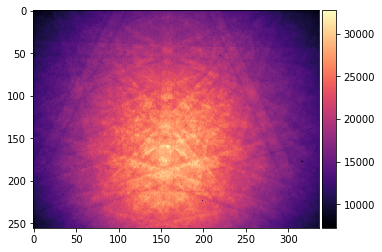

In [16]:
# get image dimensions from first image
img_filename=image_dir+'0_0.tiff'
img = Image.open(img_filename)
print('pattern dims, mode, bytes:', img.size, img.mode, len(img.getdata()))
pattern_width, pattern_height = img.size
print("pattern width, pattern height: ", pattern_width, pattern_height)

img_arr=np.array(img)

plot_image(img_arr, cmap='magma')

Enter the map parameters from CTF:     

In [17]:
# map parameters     
img_width  = pattern_width
img_height = pattern_height      
map_width  = ctf_xcells
map_height = ctf_ycells
xstepmu=ctf_xstep
ystepmu=ctf_ystep
NImages=ctf_size

Test downsampling of the data to reduce file size if possible:

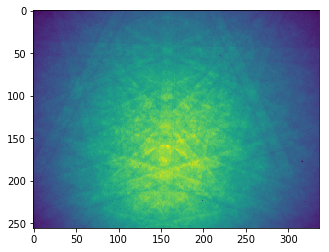

[[7520 7976 7928 ..., 8128 8232 8432]
 [7704 7912 8184 ..., 8216 8272 8184]
 [8136 7880 8080 ..., 8216 8240 8104]
 ..., 
 [8568 9088 8896 ..., 9680 9480 9552]
 [8768 9016 9000 ..., 9600 9792 9208]
 [8696 8832 8976 ..., 9504 9352 9320]]


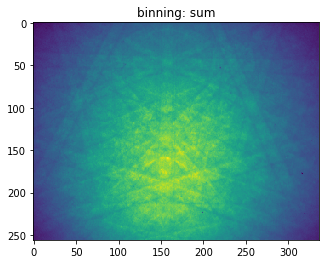

[[7520 7976 7928 ..., 8128 8232 8432]
 [7704 7912 8184 ..., 8216 8272 8184]
 [8136 7880 8080 ..., 8216 8240 8104]
 ..., 
 [8568 9088 8896 ..., 9680 9480 9552]
 [8768 9016 9000 ..., 9600 9792 9208]
 [8696 8832 8976 ..., 9504 9352 9320]]


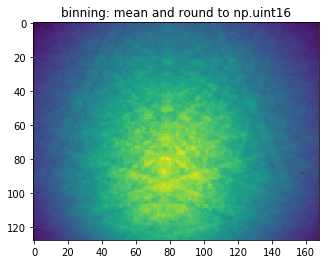

[[ 7778  8048  8108 ...,  8486  8240  8280]
 [ 8064  8184  8380 ...,  8608  8376  8166]
 [ 8156  8320  8828 ...,  8858  8796  8438]
 ..., 
 [ 9080  9234  9536 ..., 10136  9726  9762]
 [ 8870  9050  9298 ...,  9818  9704  9514]
 [ 8828  9064  9362 ..., 10028  9668  9418]]


In [18]:
# test downsampling
plt.figure()
plt.imshow(img_arr)
plt.show()
print(img_arr)

# bin by a factor of 2
binning=1

# sum the pixel intensities to retain INTEGER values in binned array (save memory in hdf5)
# we need to be sure not to exceed the 16bit integer range in the WHOLE MAP if using np.sum!
binning_estimator=np.sum
img_arr_binned=downsample(img_arr, binning, estimator=binning_estimator)
plt.figure()
plt.imshow(img_arr_binned)
plt.title('binning: sum')
plt.show()
print(img_arr_binned)

# estimator=np.nanmean will result in float values (32bit) 
# to save memory, we can use rounding and conversion to 16bit integers
binning_estimator=np.nanmean
img_arr_binned=np.rint(downsample(img_arr,2, estimator=binning_estimator)).astype(np.uint16)
plt.figure()
plt.imshow(img_arr_binned)
plt.title('binning: mean and round to np.uint16')
plt.show()
print(img_arr_binned)

Loading background from file:  ../../../xcdskd_example_data/GaN_Dislocations_1/Map_Patterns/StaticBackground.tiff
(336, 256) I;16 86016
[[2884 2920 2920 ..., 2994 2995 2992]
 [2910 2944 2954 ..., 3005 3009 2992]
 [2931 2955 2954 ..., 3050 3024 3036]
 ..., 
 [3725 3774 3783 ..., 4260 4243 4211]
 [3714 3761 3722 ..., 4297 4266 4221]
 [3704 3707 3737 ..., 4279 4220 4204]]
(256, 336)


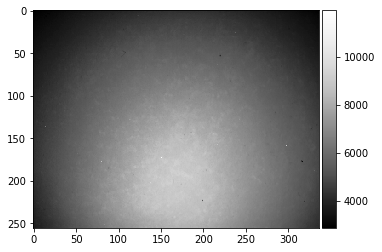

In [20]:
# flatfielding background extra file
print('Loading background from file: ', background_filename)
img = Image.open(background_filename) #.convert('LA')
print(img.size, img.mode, len(img.getdata()))
bg_binning=1

bg_img_arr =np.rint(downsample(np.array(img), bg_binning, 
                                    estimator=np.nanmean)).astype(np.uint16)

print(bg_img_arr)
print(bg_img_arr.shape)
plot_image(bg_img_arr)

In [23]:
from skimage.io import imread
def load_row_col_tiff(row, col, prefix=''):
    """
    reads an image file row_col.tiff (e.g. saved by the AZTEC EBSD software)
    """
    img_filename = prefix + str(row) + '_' + str(col) + '.tiff'
    img_arr  = imread(img_filename)
    return img_arr

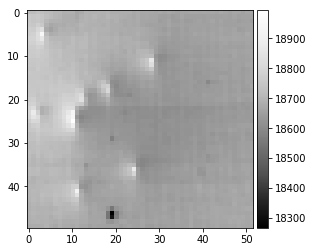

In [25]:
# make total bse map
bse_map = np.zeros((map_height, map_width))
for iw in range(map_width):
    for ih in range(map_height):
        bse_map[ih, iw] = np.nanmean(load_row_col_tiff(ih, iw, prefix=image_dir))
        
plot_image(bse_map)

In [26]:
# export to hdf5
binning=1
img_height = pattern_height // binning
img_width = pattern_width  // binning

binning_estimator=np.nanmean 

iStart=0
iEnd=NImages

DataGroup='Scan/EBSD/Data/'
HeaderGroup='Scan/EBSD/Header/'

# create new HDF5 File
f5=h5py.File(HDF5FileName,"w") # overwrite if exists
f5["Manufacturer"]="xcdskd"
f5["Version"]="0.01"

# h5ebsd HEADER INFO Data

# create empty datasets for h5ebsd format
# (empty datasets take no space)
f5.create_dataset(DataGroup+"X BEAM", (NImages,) ,dtype=np.int32,compression='gzip')
f5.create_dataset(DataGroup+"Y BEAM", (NImages,) ,dtype=np.int32,compression='gzip')
f5.create_dataset(DataGroup+"PCX" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"PCY" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"DD" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"phi1", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"PHI" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"phi2", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"X Position", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"Y Position", (NImages,) ,dtype=np.float32,compression='gzip')

f5[DataGroup+"bse_map"] = bse_map

f5[HeaderGroup+"NCOLS"] = map_width
f5[HeaderGroup+"NROWS"] = map_height
f5[HeaderGroup+"PatternHeight"] = img_height
f5[HeaderGroup+"PatternWidth"] = img_width
f5[HeaderGroup+"X Resolution"] = xstepmu  # microns
f5[HeaderGroup+"Y Resolution"] = ystepmu  # microns

# StaticBackground
#f5.create_dataset(DataGroup+"StaticBackground", (img_height,img_width), dtype=np.uint16)
f5[DataGroup+"StaticBackground"]=np.rint(downsample(bg_img_arr, binning, 
                                    estimator=binning_estimator)).astype(np.uint16)

print(f5[DataGroup+"StaticBackground"].shape)

# create empty data set for Patterns, recompress (max=9) using hdf5-gzip filter
dset_patterns=f5.create_dataset(DataGroup+'RawPatterns',
                                (NImages,img_height,img_width), 
                                dtype=np.uint16,
                                chunks=(1,img_height,img_width),
                                compression='gzip',compression_opts=9)

print(dset_patterns.shape)
print(map_width, map_height)
i=0
try:
    for iw in range(map_width):
        for ih in range(map_height):
            img_filename = str(ih)+'_'+str(iw)+'.tiff'
            img = Image.open(image_dir+img_filename)

            img_arr = np.rint(downsample(np.array(img), binning,
                                estimator=binning_estimator)).astype(np.uint16)
            dset_patterns[i]=img_arr
            # save scan indices = map position index of image i
            f5[DataGroup+"X BEAM"][i]=iw   
            f5[DataGroup+"Y BEAM"][i]=ih    

            # some dummy defaults for the projection center
            f5[DataGroup+"DD"][i]  = 1.0
            f5[DataGroup+"PCX"][i] = 0.5
            f5[DataGroup+"PCY"][i] = 0.5
            i+=1

            # live update progress info
            if (i % 25 == 0):
                progress=100.0*(i+1)/NImages
                sys.stdout.write("\rtotal patterns: %5i current:%5i progress: %4.2f%%"
                                 %(NImages,i,progress) )
                sys.stdout.flush()
                
                
    # find map indices and save index maps
    npatterns=dset_patterns.shape[0]
    XIndex = f5[DataGroup+"X BEAM"]
    YIndex = f5[DataGroup+"Y BEAM"]
    print('creating index map: ', npatterns)
    map_index=[]
    index_lookup = -1*np.ones((map_height,map_width), dtype=np.int)
    for index in range(npatterns):
        bx=XIndex[index]
        by=YIndex[index]
        map_index.append([index, bx, by])
        index_lookup[by, bx]=index
    map_index=np.array(map_index)
    print(map_index)
    #np.savetxt('./index_lookup.dat', index_lookup, fmt=' %9i ')
    f5[HeaderGroup+"maplist"] = map_index
    f5[HeaderGroup+"indexmap"] = index_lookup

finally:
    f5.close()  

(256, 336)
(2600, 256, 336)
52 50
total patterns:  2600 current: 2600 progress: 100.04%creating index map:  2600
[[   0    0    0]
 [   1    0    1]
 [   2    0    2]
 ..., 
 [2597   51   47]
 [2598   51   48]
 [2599   51   49]]


In [13]:
f5.close()           

## Test: Load the Pattern Data from the HDF5

32152
(256, 336)
(256, 336)


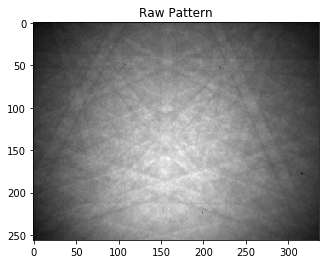

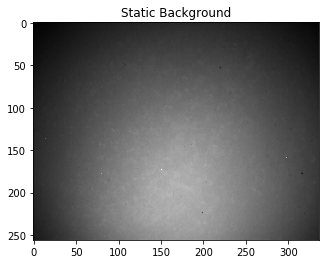

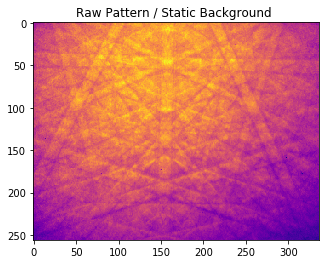

In [27]:
# which pattern to load
pattern_number = 1000

# open file for reading
f5=h5py.File(HDF5FileName, 'r') 

img=f5[DataGroup+'RawPatterns'][pattern_number]
print(np.max(img))
print(img.shape)

bg=f5[DataGroup+'StaticBackground']
print(bg.shape)

ff=img/bg

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Raw Pattern')
plt.show()

plt.figure()
plt.imshow(bg, cmap='gray')
plt.title('Static Background')
plt.show()


plt.figure()
plt.imshow(img/bg, cmap='plasma')
plt.title('Raw Pattern / Static Background ')
plt.show()

f5.close()   